# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [1]:
#| hide
from nbdev.showdoc import *

In [33]:
import math
from functools import partial
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [7]:
from cv_tools.core import *

In [15]:
#| export
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(
            self, 
            img_size=224, 
            patch_size=16, 
            in_chans=3, 
            embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(
            in_chans, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
            )

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [18]:
IMAGE_SIZE=224
PATCH_SIZE=16
EMBED_DIM=768
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) * (IMAGE_SIZE // PATCH_SIZE)
print(NUM_PATCHES)
patch_embed = PatchEmbed(
    img_size=224,
    patch_size=16,
    in_chans=3,
    embed_dim=768
)

x = torch.randn(1, 3, 224, 224)
patch_embed(x).shape

196


torch.Size([1, 196, 768])

In [21]:
pos_embedding=nn.Parameter(torch.zeros(1, NUM_PATCHES, EMBED_DIM), requires_grad=False)

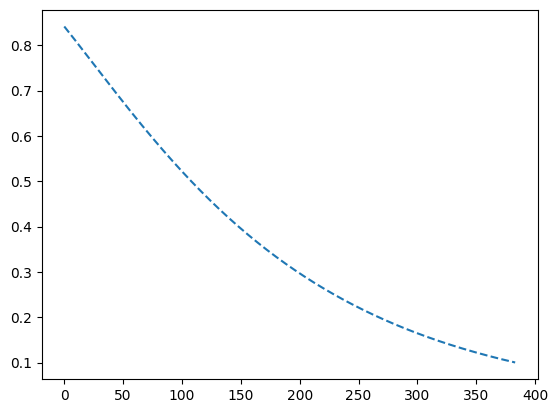

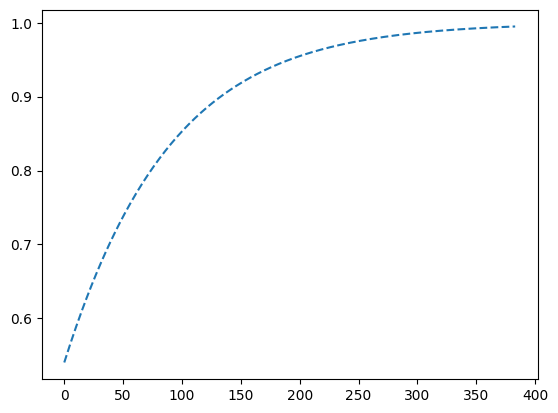

In [41]:
omega = np.arange(EMBED_DIM //2, dtype=float)
omega_  = omega / EMBED_DIM / 2.
plt.plot(omega, np.sin(1/10000**omega_),'--')
plt.show()
plt.plot(omega, np.cos(1/10000**omega_),'--')

In [43]:
#| export
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)

    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [44]:
#| export
def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

In [52]:
GRID_SIZE = 10
EMBED_DIM = 60
positional_embeddings = get_1d_sincos_pos_embed(
    EMBED_DIM, 
    GRID_SIZE, 
    cls_token=False)
positional_embeddings.shape


(10, 60)

In [57]:
#| export
def plot_pos_embed(
     positional_embeddings,
     embed_dim
     ):
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(embed_dim):
        ax.plot(positional_embeddings[:, i], label=f'Dimension {i+1}')
    plt.xlabel('Position Index')
    plt.ylabel('Embedding Value')
    plt.legend()
    plt.show()

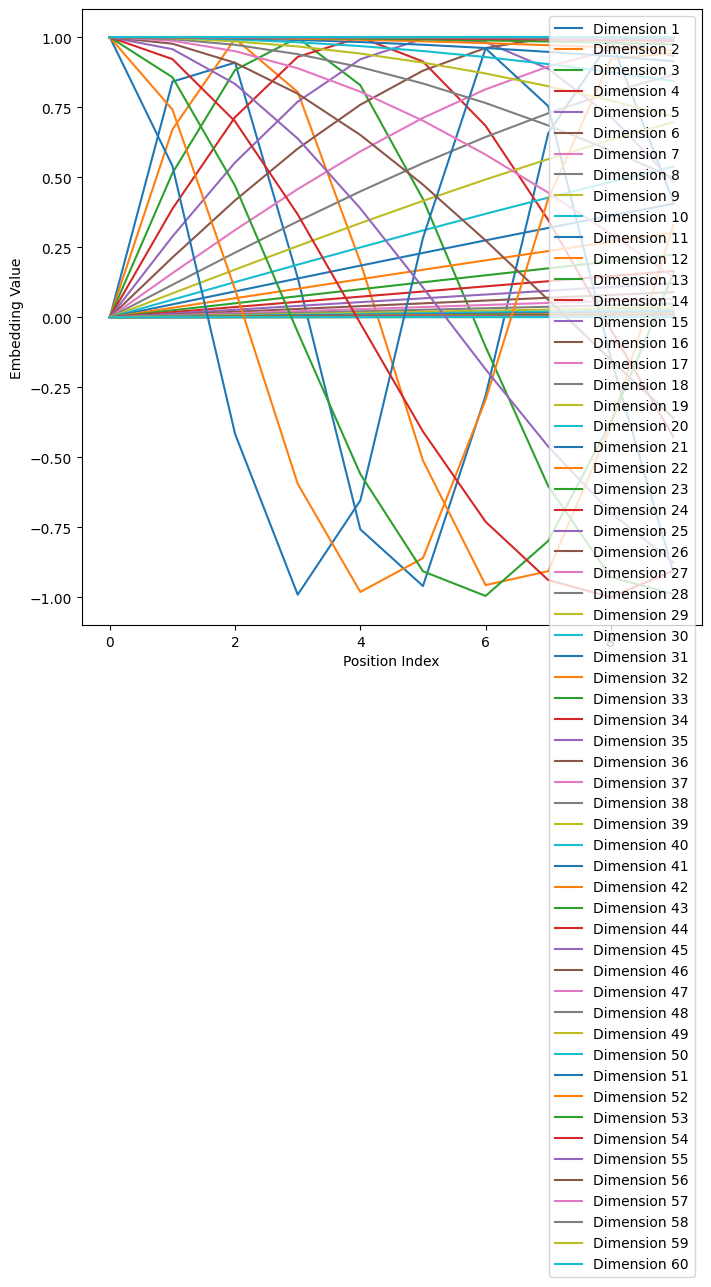

In [58]:
plot_pos_embed(positional_embeddings, EMBED_DIM)

(11, 60)


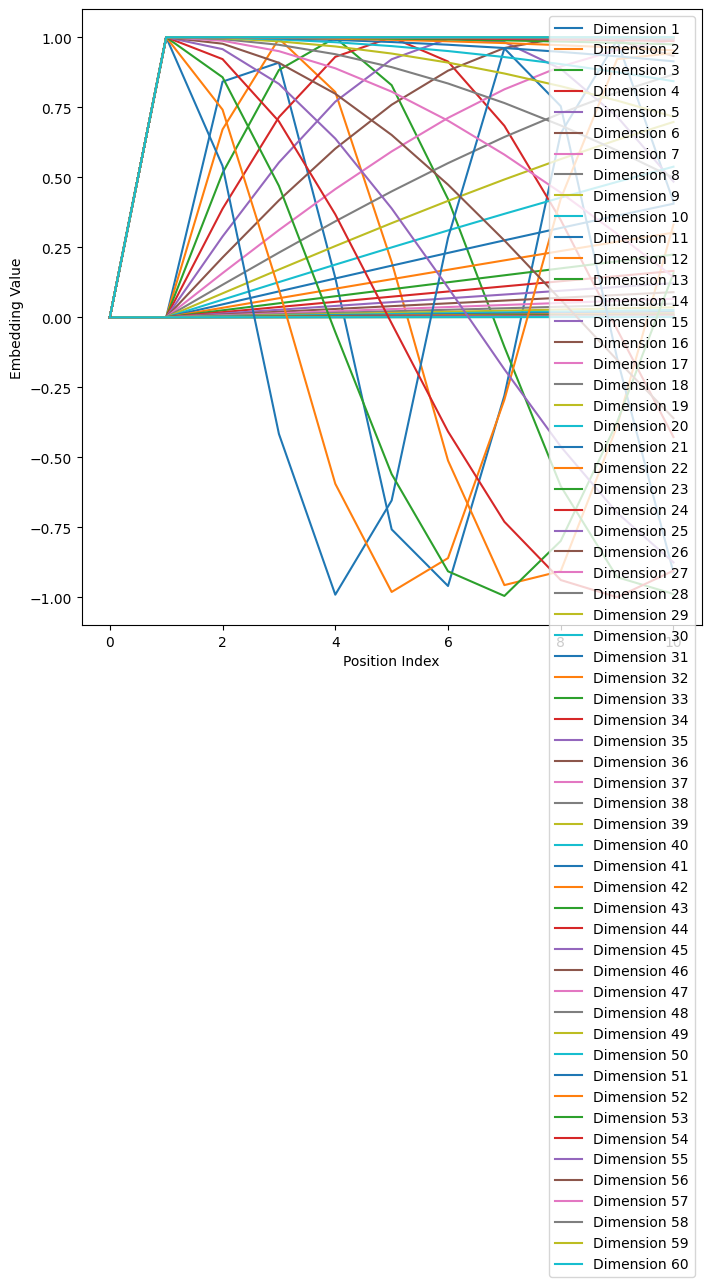

In [60]:
positional_embeddings = get_1d_sincos_pos_embed(
    EMBED_DIM, 
    GRID_SIZE, 
    cls_token=True)
print(positional_embeddings.shape)

plot_pos_embed(positional_embeddings, EMBED_DIM)


In [81]:
#| export
def get_2d_sincos_pos_embed_from_grid(
        embed_dim, 
        grid
        ):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb

In [84]:
#| export
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

In [88]:
 # --
dpr = [x.item() for x in torch.linspace(0, 0.0, 12)]  # stochastic depth decay rule
dpr

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
#| export
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(
        self,
        img_size=[224],
        patch_size=16,
        in_chans=3,
        embed_dim=768,
        predictor_embed_dim=384,
        depth=12,
        predictor_depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        init_std=0.02,
        **kwargs
    ):

        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads

        # --
        self.patch_embed = PatchEmbed(
            img_size=img_size[0],
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim)

        num_patches = self.patch_embed.num_patches
        # --

        # first creating an array with zeros
        self.pos_embed = nn.Parameter(
                                torch.zeros(1, num_patches, embed_dim), 
                                requires_grad=False)

        # creating positional embeddings based on the grid size and patch size
        pos_embed = get_2d_sincos_pos_embed(
                        embed_dim=self.pos_embed.shape[-1],
                        grid_size=int(self.patch_embed.num_patches**.5),
                                            cls_token=False)
        # copying the positional embeddings to the pos_embed tensor
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))


        # --


In [ ]:
#| export
def foo(): pass

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()